<img src="https://www.mymetrotex.com/wp-content/uploads/2021/06/Untitled-design-2020-09-28T130055.657.png" />

![Screenshot](ca_county.png)

---

<div class="alert alert-block alert-info">

# Business Goals:
### 1. Construct an ML Regression model to predict property tax assessed values of Single Family Homes.

### 2. Find the key drivers of property value for single family properties.

### 3. Deliver a report to understand what steps were taken, why and what the outcome was.

### 4. Make recommendations to better predict SFH home values.

---

# Project Summary:


### 1. Using 7 features out of the 62 showed the most promise to have a generalized and not overfit model
### 2. The Ordinary Least Squared model came out on top with the least amount of error to predict the value of a SFH.
### 3. Over half of the original data are homes in Los Angeles County. Only 10% of homes were located in Ventura county.
### 4. Almost 40% of data fell in the outlier range and was removed to focus down on a more "standard" home.

---

## Imports:

In [1]:
# Standard imports
import numpy as np
import pandas as pd

# For statistical modeling
import scipy.stats as stats

# To acquire MYSQL Data
import acquire
from env import username, password, host
from wrangle import scale_data, train_validate_test, wrangle_zillow, remove_outliers, rfe, rmse, pf, lasso_lars, glm, pf_test, value_viz, pred_act, no_error, test, vis, graph
import evaluate

# For data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# To avoid deprecation and other warnings
import warnings
warnings.filterwarnings('ignore')

# For modeling
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LogisticRegression, LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector

## Questions:
    - What are the most important features that determine a home's value?
    - How many homes are outside the ordinary from a "regular home"?
    - How much does location play a part in value?

---

<div class="alert alert-block alert-warning">
    
# Acquisition:

### First acquire the data from my .csv file

In [2]:
# Data saved to a csv. from a SQL query
zillow = pd.read_csv('zillow_2017_w_transactiondate.csv')
zillow.head()

,Unnamed: 0,propertylandusetypeid,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate,propertylandusedesc
0,0,261.0,14297519,1727539,NaN,NaN,NaN,3.5,4.0,NaN,...,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,0,0.025595,2017-01-01,Single Family Residential
1,1,261.0,17052889,1387261,NaN,NaN,NaN,1.0,2.0,NaN,...,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,1,0.055619,2017-01-01,Single Family Residential
2,2,261.0,14186244,11677,NaN,NaN,NaN,2.0,3.0,NaN,...,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,2,0.005383,2017-01-01,Single Family Residential
3,3,261.0,12177905,2288172,NaN,NaN,NaN,3.0,4.0,NaN,...,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,3,-0.103410,2017-01-01,Single Family Residential
4,4,266.0,10887214,1970746,1.0,NaN,NaN,3.0,3.0,NaN,...,2016.0,45726.0,1533.89,NaN,NaN,6.037124e+13,4,0.006940,2017-01-01,Condominium


### 52442 original observations of SFH that had a transaction date in 2017 with 62 features (removing ID columns)

---

<div class="alert alert-block alert-warning">

# Preparation: 

## Analysis will be focused on Single Family Homes
### - Within the wrangle file, I will be using a function that only includes SFH and 7 features to predict Tax Value
### - I viewed each feature's nulls, value counts, etc. and determined if it should be kept or removed (influencing the wrangle_zillow function).
### - That same function imputes either the median, mode, or a random int within a certain range for any null values

### How many homes are outside the ordinary from a "regular home"?

In [3]:
# This function (found in wrangle) takes in the Zillow Dataframe, reassigns it so only properties that are SFH 
# and had a transaction in 2017 remain. It then renames columns, imputes nulls values, and then removes outliers.
zillow = wrangle_zillow(zillow)
zillow.head(3)

Number of observations removed: 19014
Percentage of original Dataframe removed: 0.36


,bathrooms,bedrooms,bldg_quality,f_sqft,fips,lot_size,zip,tax_value
0,3.5,4.0,7.0,3100.0,6059.0,4506.0,96978.0,1023282.0
1,1.0,2.0,7.0,1465.0,6111.0,12647.0,97099.0,464000.0
2,2.0,3.0,7.0,1243.0,6059.0,8432.0,97078.0,564778.0


### Remaining rows: 33,427

---

<div class="alert alert-block alert-warning">

# Exploration and Pre-Processing:

### I started using some knowledge of how home prices are determined that I previously possessed to narrow down on features
### The Recursive Feature Elimination (RFE) declared that Bedrooms, Bathrooms, Building Quality, Square Footage and Zip Code were the five most useful features.

---

## How much does location play a part in value?

In [4]:
# distribution of the home values
zillow.fips.value_counts(normalize=True)

6037.0    0.566877
6059.0    0.331229
6111.0    0.101894
Name: fips, dtype: float64

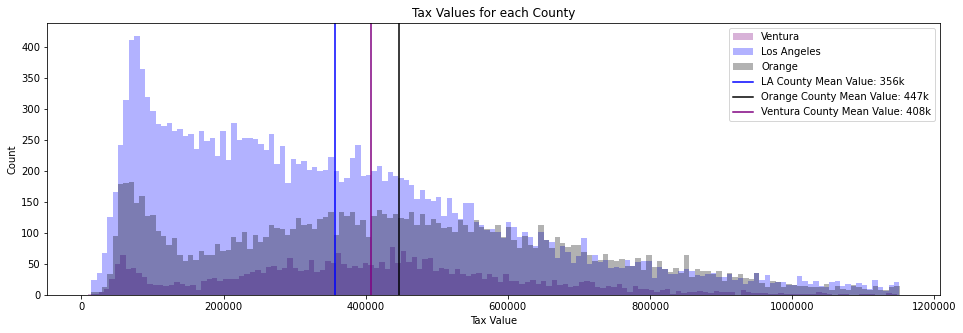

In [5]:
# Visualization function that shows distribution of property value in each county
value_viz(zillow)

### LA County skews the data to the left and has a lower average property value

We reject that bedrooms and bathrooms are independent
There is a relationship between bathrooms and bedrooms


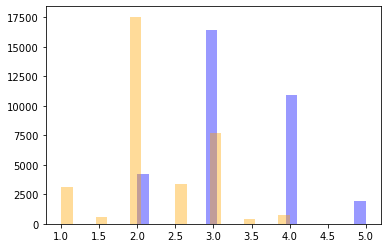

In [6]:
# Compare two features and determine if they are related to each other
graph(zillow, 'bedrooms', 'bathrooms')

We reject that bldg_quality and bedrooms are independent
There is a relationship between bedrooms and bldg_quality


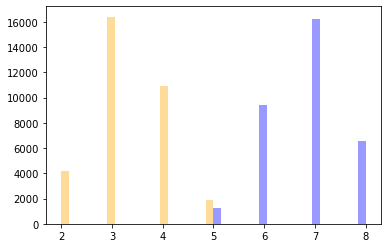

In [7]:
# Compare two features and determine if they are related to each other
graph(zillow, 'bldg_quality', 'bedrooms')

---

## Lastly, the data will be separated in to Train, Validate, and Test

In [8]:
# Splits into train, validate, test and creates X, Y, where Y holds the target feature
X_train, y_train, X_validate, y_validate, X_test, y_test = train_validate_test(zillow, 'tax_value')

---

<div class="alert alert-block alert-warning">

# Modeling:

### First, the Root Squared Error for the Mean and Median were computed

In [9]:
# This function determines the RMSE score when comparing actual values against the Mean and Median values of a dataframe
rmse(y_train, y_validate, 'tax_value')

R̲M̲S̲E

Using Mean:
Train(In-Sample):        246245
Validate(Out-of-Sample): 248493

Using Median:
Train(In-Sample):        247946
Validate(Out-of-Sample): 249889


In [10]:
# This function creates, fits and uses a Lasso+Lars Model and returns the RMSE score
lasso_lars(X_train, y_train, X_validate, y_validate, X_test, y_test, 'tax_value', 0)

L̲a̲s̲s̲o̲ ̲+̲ ̲L̲a̲r̲s

RMSE for Training/In-Sample:        218205
RMSE for Validation/Out-of-Sample:  221171
R^2 Validate:                       0.208


In [11]:
# This function creates, fits and uses a Generalized Linear Model and returns the RMSE score
glm(X_train, y_train, X_validate, y_validate, X_test, y_test, 'tax_value', 0, 0)

G̲L̲M̲ ̲u̲s̲i̲n̲g̲ ̲T̲w̲e̲e̲d̲i̲e

RMSE for Training/In-Sample:        218412
RMSE for Validation/Out-of-Sample:  221232
R^2 Validate:                       0.207


In [12]:
# This function creates, fits and uses a Polynomial Regression Model and returns the RMSE score
pf(X_train, y_train, X_validate, y_validate, X_test, y_test, 'tax_value', 3)

O̲L̲S̲ ̲u̲s̲i̲n̲g̲ ̲L̲i̲n̲e̲a̲r̲R̲e̲g̲r̲e̲s̲s̲i̲o̲n

RMSE for Training/In-Sample:        207982
RMSE for Validation/Out-of-Sample:  212982
R^2 Validate:                       0.265


In [13]:
# This function uses a Polynomial Regression Model and returns the RMSE score for the test data
pf_test(X_train, y_train, X_test, y_test, 'tax_value', 3)

RMSE for Test:  207106
R^2 Test:        0.282


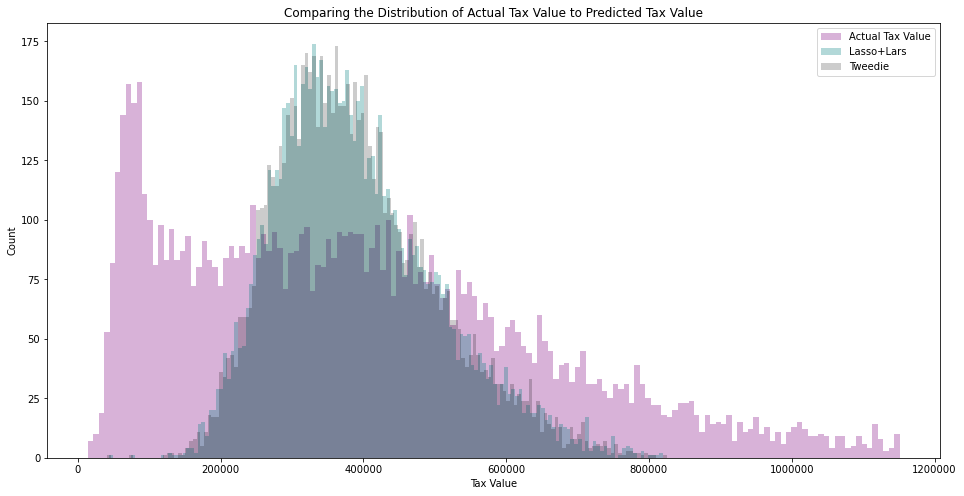

In [14]:
# Compares the predicted values to the actual values for the Lasso-Lars and the Tweeidie model
pred_act(y_validate)

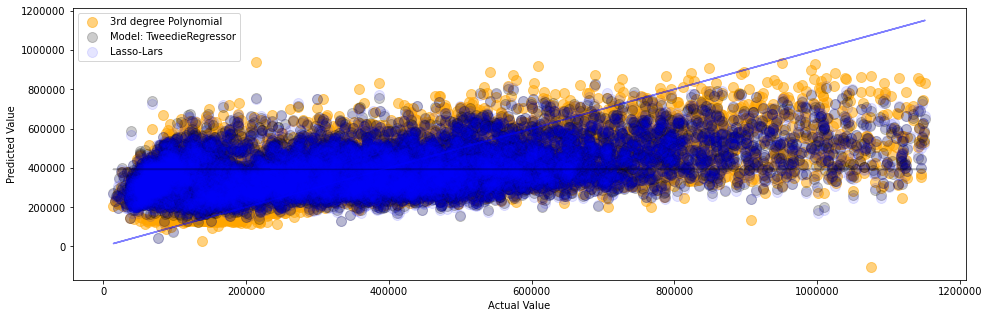

In [15]:
# Function to see which models predictions have smaller margins of error
no_error(y_validate)

---

<div class="alert alert-block alert-success">

# Findings:
## 1. Square footage, Number of Bedrooms, Number of Bathrooms, Lot Size are essential features for property value
## 2. Location, Location, location... is the most vital aspect for value determination
## 3. More than half the homes were located in Los Angeles County, 10% were in Ventura County
## 4. The model didn't fair well in valuing homes on both the low and high end of the data

# Recommendations:
## 1. Focus models on bedrooms, bathrooms, sqft, and more narrow location features
## 2. Aim regression models more precisely on homes valued at between 200,000 and 600,000 for better results

---

<div class="alert alert-block alert-info">

# More exploration can be found in the zillow_project_notebook.ipynb file